In [1]:
import anndata as ad
import pandas as pd
import scanpy as sc
from PIL import Image
import numpy as np

In [2]:
# MERFISH file downloaded from https://singlecell.broadinstitute.org/single_cell/study/SCP2702/htapp-mbc#study-download
merfish = sc.read_h5ad("/Users/jychien/Downloads/merfish_bin.h5ad")

In [3]:
merfish

AnnData object with n_obs × n_vars = 361972 × 291
    obs: 'replicate', 'RCTD', 'OT', 'OT_max', 'x', 'y', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'counts_var', 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'OT', 'OT_max', 'RCTD', 'X_pca', 'X_umap', 'counts'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
sc.set_figure_params(figsize=(15,15))

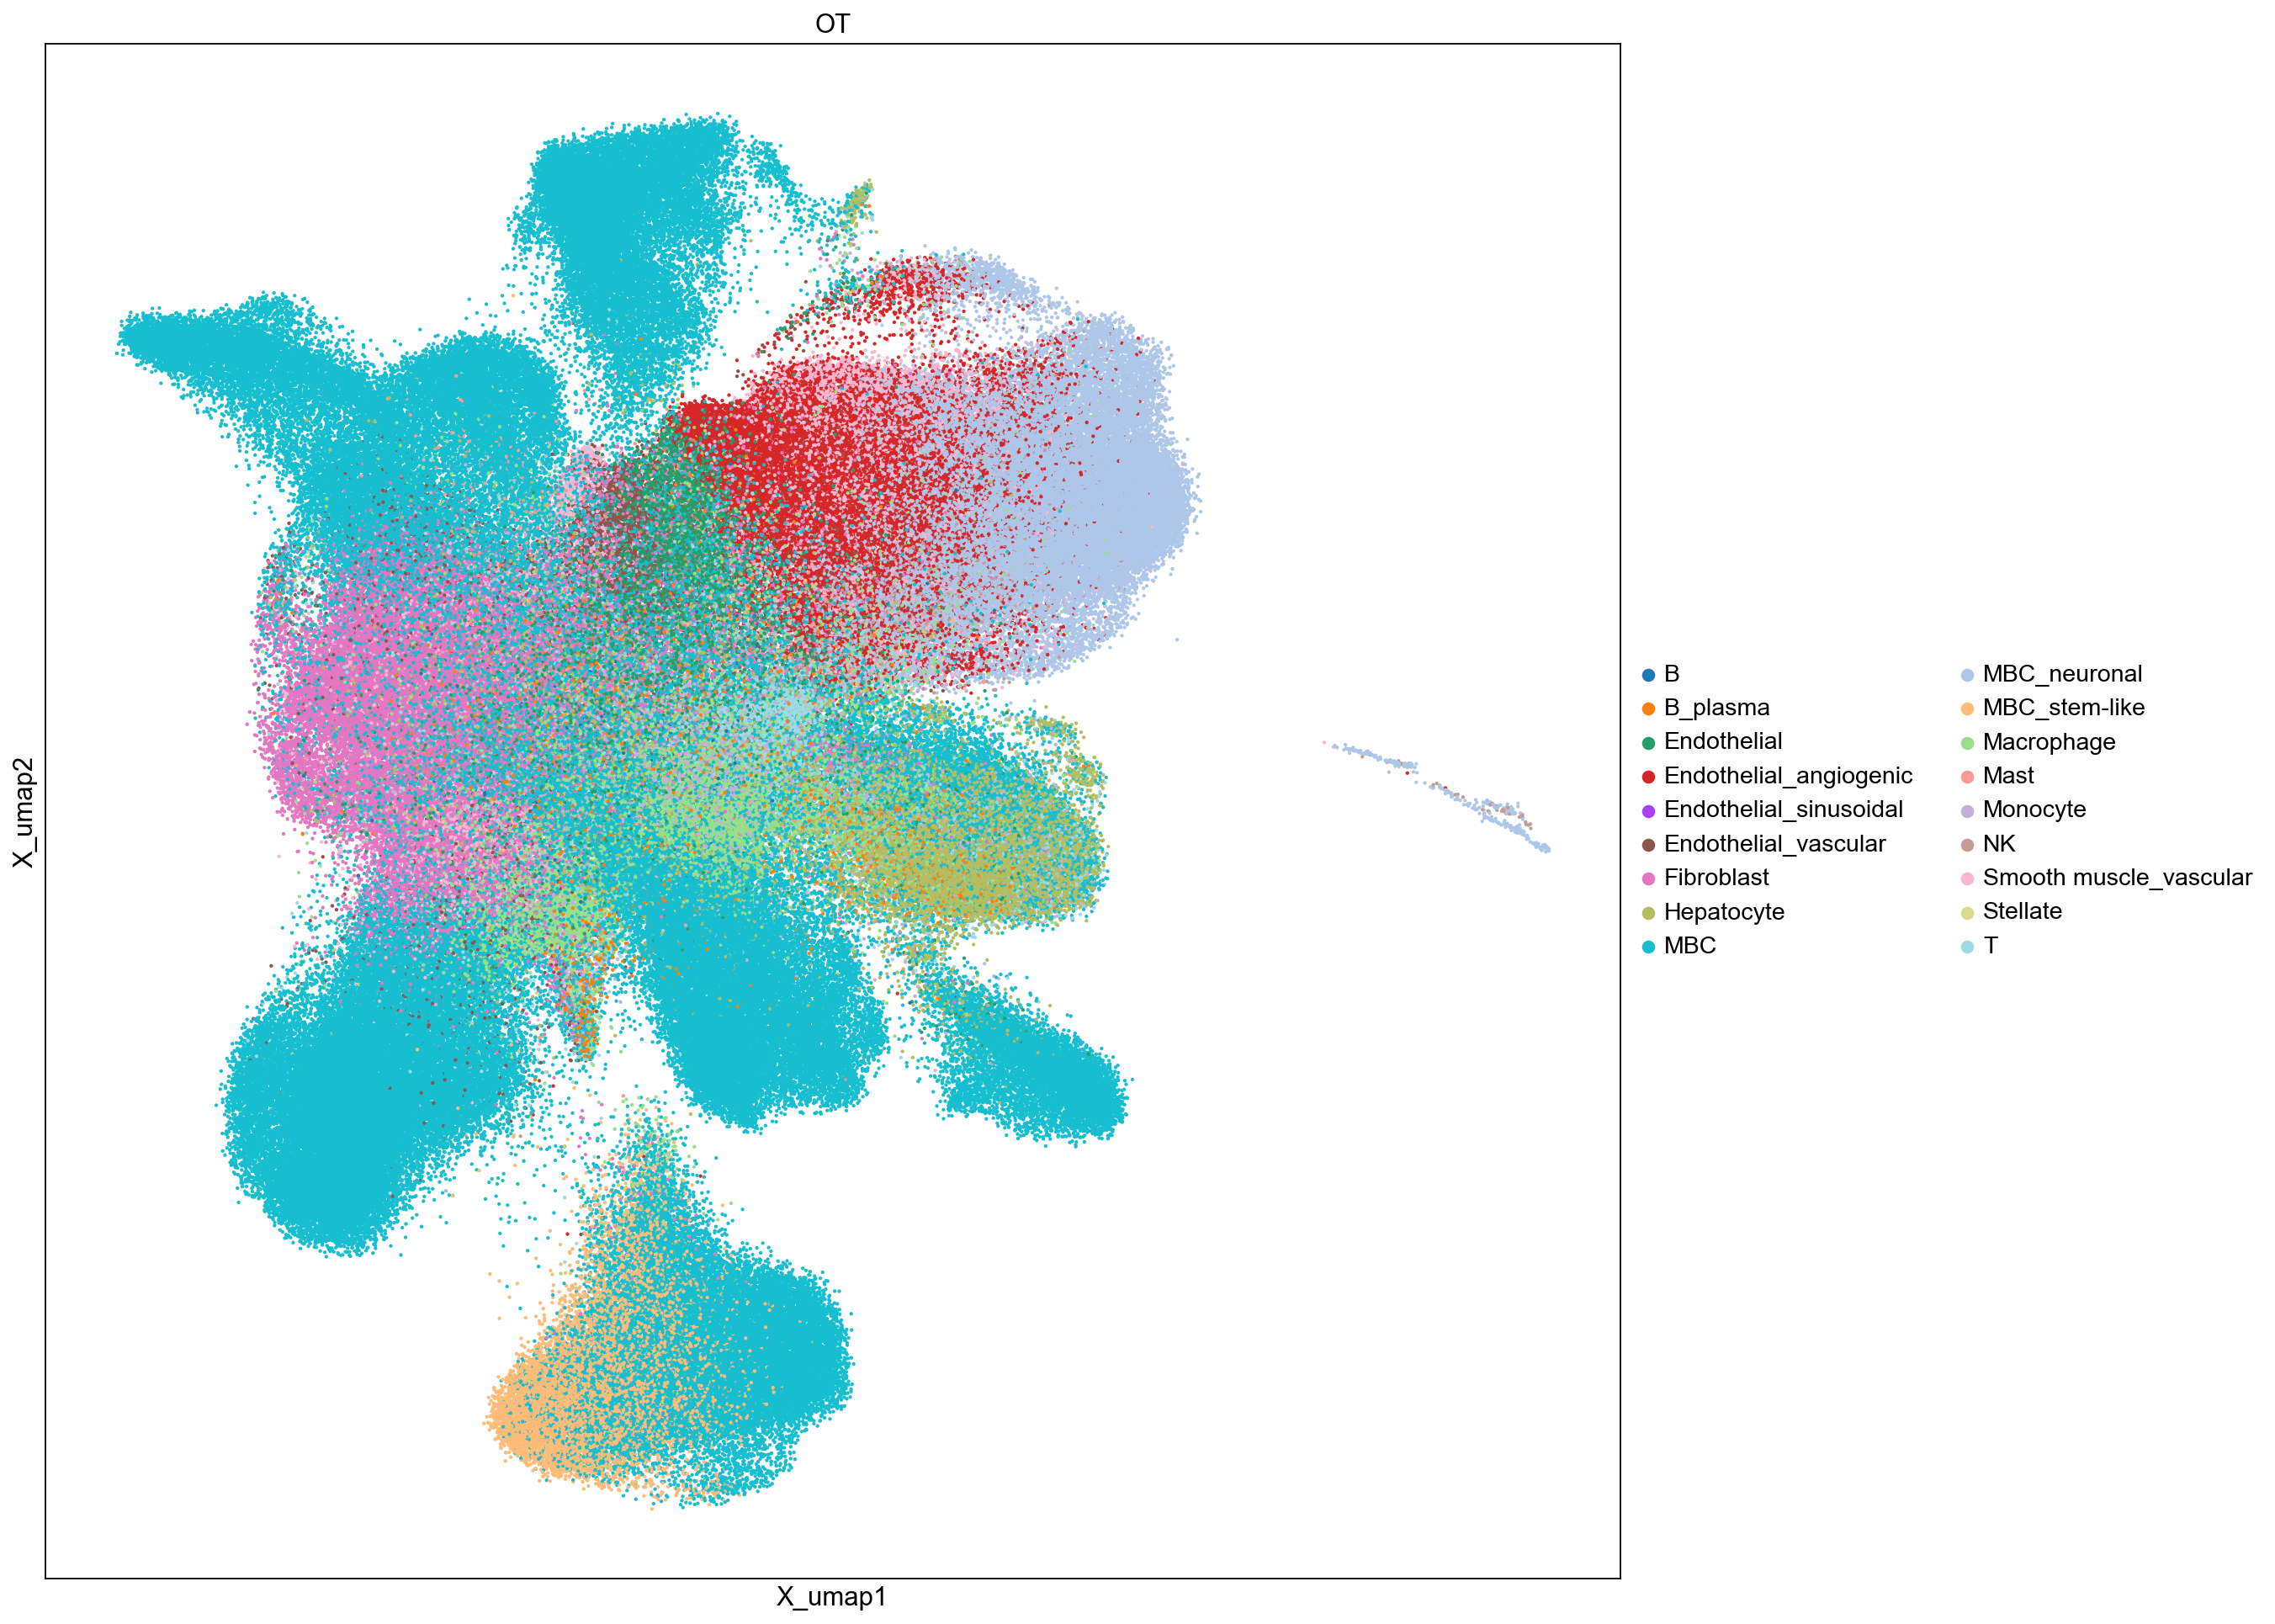

In [5]:
sc.pl.embedding(merfish, basis='X_umap', color='OT', size=15, legend_loc='right margin', legend_fontweight='bold')

In [6]:
merfish.obs.iloc[1,:]

replicate                             1
RCTD                         Macrophage
OT                             Monocyte
OT_max                         Monocyte
x                           1168.299644
y                           4122.233508
sample               HTAPP-944-SMP-7479
n_genes_by_counts                    36
total_counts                       60.0
total_counts_mt                     0.0
pct_counts_mt                       0.0
n_counts                           60.0
leiden                                0
Name: cell100351-1-HTAPP-944-SMP-7479, dtype: object

In [7]:
merfish.obs['sample'].value_counts()

sample
HTAPP-944-SMP-7479    82268
HTAPP-514-SMP-6760    65053
HTAPP-982-SMP-7629    49628
HTAPP-917-SMP-4531    42959
HTAPP-313-SMP-932     41480
HTAPP-878-SMP-7149    40024
HTAPP-812-SMP-8239    16453
HTAPP-880-SMP-7179    12092
HTAPP-853-SMP-4381    12015
Name: count, dtype: int64

In [8]:
merfish.obs['sample'].unique()[0]

'HTAPP-944-SMP-7479'

In [9]:
# Subset to the sample of interest
merfish_subsets = []
for i in merfish.obs['sample'].cat.categories.to_list():
    merfish_subset = merfish[merfish.obs['sample']==i].copy()
    merfish_subsets.append(merfish_subset)

In [10]:
merfish_subsets[0]

AnnData object with n_obs × n_vars = 82268 × 291
    obs: 'replicate', 'RCTD', 'OT', 'OT_max', 'x', 'y', 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'counts_var', 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'OT_colors'
    obsm: 'OT', 'OT_max', 'RCTD', 'X_pca', 'X_umap', 'counts'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
# Downloaded images from HTAN portal
# https://htan-portal-nextjs-git-fork-leexgh-mbc-publication-page-htan.vercel.app/publications/hta1_2024_pdf_johanna-klughammer?tab=h%26e
# Store image in adata.uns['image']

from PIL import Image
Image.MAX_IMAGE_PIXELS = 699408640
for adata in merfish_subsets:
    fullres_path = '/Users/jychien/Downloads/' + adata.obs['sample'].unique()[0] + '_HE_1_processed.jpg'
    fullres_np = np.asarray(Image.open(fullres_path))
    adata.uns['image'] = fullres_np

In [12]:
merfish_subset.obs.columns

Index(['replicate', 'RCTD', 'OT', 'OT_max', 'x', 'y', 'sample',
       'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt',
       'n_counts', 'leiden'],
      dtype='object')

In [13]:
# Add spatial X/Y coordinate into obsm
for adata in merfish_subsets:
    adata.obsm['spatial'] = adata.obs[['x','y']].to_numpy()

In [14]:
sc.set_figure_params(figsize=(30,30))

In [15]:
# Isolate just the fibroblasts
fibroblasts = merfish_subset[merfish_subset.obs['OT']=='Fibroblast',:]

In [1]:
# Plot with H&E underlay
# for adata in merfish_subsets:
#     print(adata.obs['sample'].unique()[0])
#     sc.pl.spatial(adata[adata.obs['OT']=='Fibroblast'], basis='spatial', color='OT', \
#                   spot_size=20, img=adata.uns['image'], palette = 'Dark2')

In [17]:
# Create gene lists based off of Cords et al. that were found in MERFISH
mCAF = ['MMP11','CSTB']
iCAF = ['APOC1','CD34','CLU','CTSL','EGFR']
vCAF = ['CD9','FOXC1','ACTA2']
ifnCAF = ['BLVRA']
apCAF = ['HLA-DRA','HLA-DRB1','CD74']
rCAF = ['CALCRL','EIF3E']
dCAF = ['AKT1','MKI67']

In [18]:
# Generate gene list scores using score_genes()
for adata in merfish_subsets:
    sc.tl.score_genes(adata, mCAF)
    adata.obs.rename(columns={'score':'mCAF_score'}, inplace=True)
    sc.tl.score_genes(adata, iCAF)
    adata.obs.rename(columns={'score':'iCAF_score'}, inplace=True)
    sc.tl.score_genes(adata, vCAF)
    adata.obs.rename(columns={'score':'vCAF_score'}, inplace=True)
    sc.tl.score_genes(adata, ifnCAF)
    adata.obs.rename(columns={'score':'ifnCAF_score'}, inplace=True)
    sc.tl.score_genes(adata, apCAF)
    adata.obs.rename(columns={'score':'apCAF_score'}, inplace=True)
    sc.tl.score_genes(adata, rCAF)
    adata.obs.rename(columns={'score':'rCAF_score'}, inplace=True)
    sc.tl.score_genes(adata, dCAF)
    adata.obs.rename(columns={'score':'dCAF_score'}, inplace=True)

In [19]:
merfish_subsets[0].obs.iloc[1,:]

replicate                             1
RCTD                         Macrophage
OT                             Monocyte
OT_max                         Monocyte
x                           1168.299644
y                           4122.233508
sample               HTAPP-944-SMP-7479
n_genes_by_counts                    36
total_counts                       60.0
total_counts_mt                     0.0
pct_counts_mt                       0.0
n_counts                           60.0
leiden                                0
mCAF_score                          0.0
iCAF_score                      1.49003
vCAF_score                    -0.776057
ifnCAF_score                  -0.465634
apCAF_score                    3.366164
rCAF_score                     2.095355
dCAF_score                          0.0
Name: cell100351-1-HTAPP-944-SMP-7479, dtype: object

In [30]:
sc.set_figure_params(figsize=(15,40), fontsize=20)

In [2]:
# Plot scores for a
# for adata in merfish_subsets:
#     print(adata.obs['sample'].unique()[0])
#     sc.pl.spatial(adata[adata.obs['OT']=='Fibroblast'], basis='spatial', 
#                   color=['mCAF_score','iCAF_score','vCAF_score','ifnCAF_score','apCAF_score','rCAF_score','dCAF_score'],
#                   spot_size=20, img=adata.uns['image'], alpha_img=0.50, )